**In this project, a linear programming optimization model was formulated to select the optimum locations for opening production plants for a hypothetical business. The dummy dataset contains a set of parameters for the 5 locations namely, USA, Germany, Japan, Brazil and India. The parameters include:**

- Variable cost of production (dollars/unit).
- Variable cost of transportation (dollars/unit).
- Fixed cost of opening a plant at each of the locations.
- Capacity of production plant at each of the locations.
- Demand at each of the locations.

The linear programming model finds the optimum locations for opening the plants with the objective of minimizing cost while fulfilling the capacity and demand constraints.

## Imporitng Libraries and Datasets 

In [32]:
from pulp import *
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict

In [33]:
#Manufacturing cost per unit
man_costs = pd.read_excel("data/variable costs.xlsx", index_col=0)
man_costs

,USA,GERMANY,JAPAN,BRAZIL,INDIA
Variable Costs ($/Unit),,,,,
USA,12,12,12,12,12
GERMANY,13,13,13,13,13
JAPAN,10,10,10,10,10
BRAZIL,8,8,8,8,8
INDIA,5,5,5,5,5


In [34]:
#Freight cost per unit
freight_costs = pd.read_excel("data/freight costs.xlsx", index_col=0)
freight_costs = freight_costs
freight_costs

,USA,GERMANY,JAPAN,BRAZIL,INDIA
Freight Costs ($/Container),,,,,
USA,0,1750,1100,2300,1254
GERMANY,1905,0,1231,2892,1439
JAPAN,2200,3250,0,6230,2050
BRAZIL,2350,3150,4000,0,4250
INDIA,1950,2200,3500,4200,0


In [35]:
#Total variable cost per unit
var_costs = man_costs+freight_costs/1000
var_costs

,USA,GERMANY,JAPAN,BRAZIL,INDIA
Variable Costs ($/Unit),,,,,
USA,12.000,13.75,13.100,14.300,13.254
GERMANY,14.905,13.00,14.231,15.892,14.439
JAPAN,12.200,13.25,10.000,16.230,12.050
BRAZIL,10.350,11.15,12.000,8.000,12.250
INDIA,6.950,7.20,8.500,9.200,5.000


In [36]:
#Total fixed cost per unit
fixed_costs = pd.read_excel("data/fixed cost.xlsx", index_col=0)
fixed_costs

,LOW,HIGH
USA,6500,9500
GERMANY,4980,7270
JAPAN,6230,9100
BRAZIL,3230,4730
INDIA,2110,6160


In [37]:
#Plant capacities
capacities = pd.read_excel("data/capacity.xlsx", index_col=0)
capacities

,LOW,HIGH
Capacity (kUnits/month),,
USA,500,1500
GERMANY,500,1500
JAPAN,500,1500
BRAZIL,500,1500
INDIA,500,1500


In [38]:
#Market demands
demands = pd.read_excel("data/demand.xlsx", index_col=0)
demands

,Demand
(Units/month),
USA,2800000
GERMANY,90000
JAPAN,1700000
BRAZIL,145000
INDIA,160000


## Defining the Optimization Model Function

In [39]:
def optimize(var_costs, fixed_costs, demand_df, demand_col, capacities):
    locations = ["USA", "GERMANY", "JAPAN", "BRAZIL", "INDIA"]
    sizes = ["LOW", "HIGH"]
    location_to_location = [(i,j) for i in locations for j in locations] 
    location_to_size = [(i,s) for s in sizes for i in locations]
    model = LpProblem("Optimize_location_and_supply", LpMinimize)
    x = LpVariable.dicts("plant_opening", location_to_size, cat="Binary")
    y = LpVariable.dicts("units_supplied", location_to_location, lowBound=0, upBound=None, cat="Continuous")
    
    model += (lpSum([fixed_costs.loc[i,s]*x[(i,s)]*1000 for s in sizes for i in locations])+
             lpSum([var_costs.loc[i,j]*y[(i,j)] for i in locations for j in locations]))
    
    for j in locations:
        model += lpSum([y[(i,j)] for i in locations]) == demand_df.loc[j, demand_col]
    for i in locations:
        model += lpSum([y[(i,j)] for j in locations]) <= lpSum([capacities.loc[i,s]*x[(i,s)]*1000 for s in sizes])
    
    model.solve()
    
    status = LpStatus[model.status]
    objective_value = int(pulp.value(model.objective))
    df_plant_opening = pd.DataFrame(data=[x[(i,s)].varValue for s in sizes for i in locations], index = [i + "_" + s for s in sizes for i in locations], columns = ["Open"])
    
    return status, objective_value, df_plant_opening

## Generating Scenarios with Variable Demands

In [40]:
locations = ["USA", "GERMANY", "JAPAN", "BRAZIL", "INDIA"]
demand_df = defaultdict(list)

for location in locations:
    mean = demands.loc[location, "Demand"]
    coeff_variation = 0.5
    demand_array = np.random.normal(mean, coeff_variation*mean,49)//1
    demand_array = [d if d>=0 else 0 for d in demand_array]
    demand_df[location] = demand_array
    
demand_df = pd.DataFrame(demand_df)
demand_df.T

,0,1,2,3,4,5,6,7,8,9,...,39,40,41,42,43,44,45,46,47,48
USA,2539997.0,370571.0,1379334.0,1373396.0,3587373.0,4072024.0,645311.0,3424091.0,4160829.0,1251066.0,...,1524063.0,2601617.0,2631759.0,1341728.0,3701575.0,2146926.0,4110654.0,1120014.0,4128444.0,4920312.0
GERMANY,106845.0,121698.0,21474.0,105155.0,16817.0,27817.0,91611.0,79617.0,0.0,3549.0,...,114020.0,87585.0,142552.0,51945.0,48.0,79658.0,99056.0,59911.0,142846.0,0.0
JAPAN,2619739.0,2951266.0,2047859.0,1567627.0,719028.0,1570813.0,2341146.0,2339827.0,781426.0,964546.0,...,1473523.0,3123283.0,2689927.0,1149558.0,1665355.0,2292677.0,1607212.0,1910144.0,1032166.0,1744480.0
BRAZIL,205611.0,188115.0,140384.0,208811.0,158235.0,121092.0,153388.0,17326.0,149523.0,77074.0,...,3594.0,124228.0,151144.0,124171.0,121728.0,81372.0,75511.0,183143.0,135193.0,173442.0
INDIA,192708.0,164792.0,192879.0,28050.0,129439.0,0.0,189297.0,1177.0,210026.0,104233.0,...,56897.0,161111.0,91665.0,308508.0,77630.0,211570.0,323523.0,259402.0,172362.0,195490.0


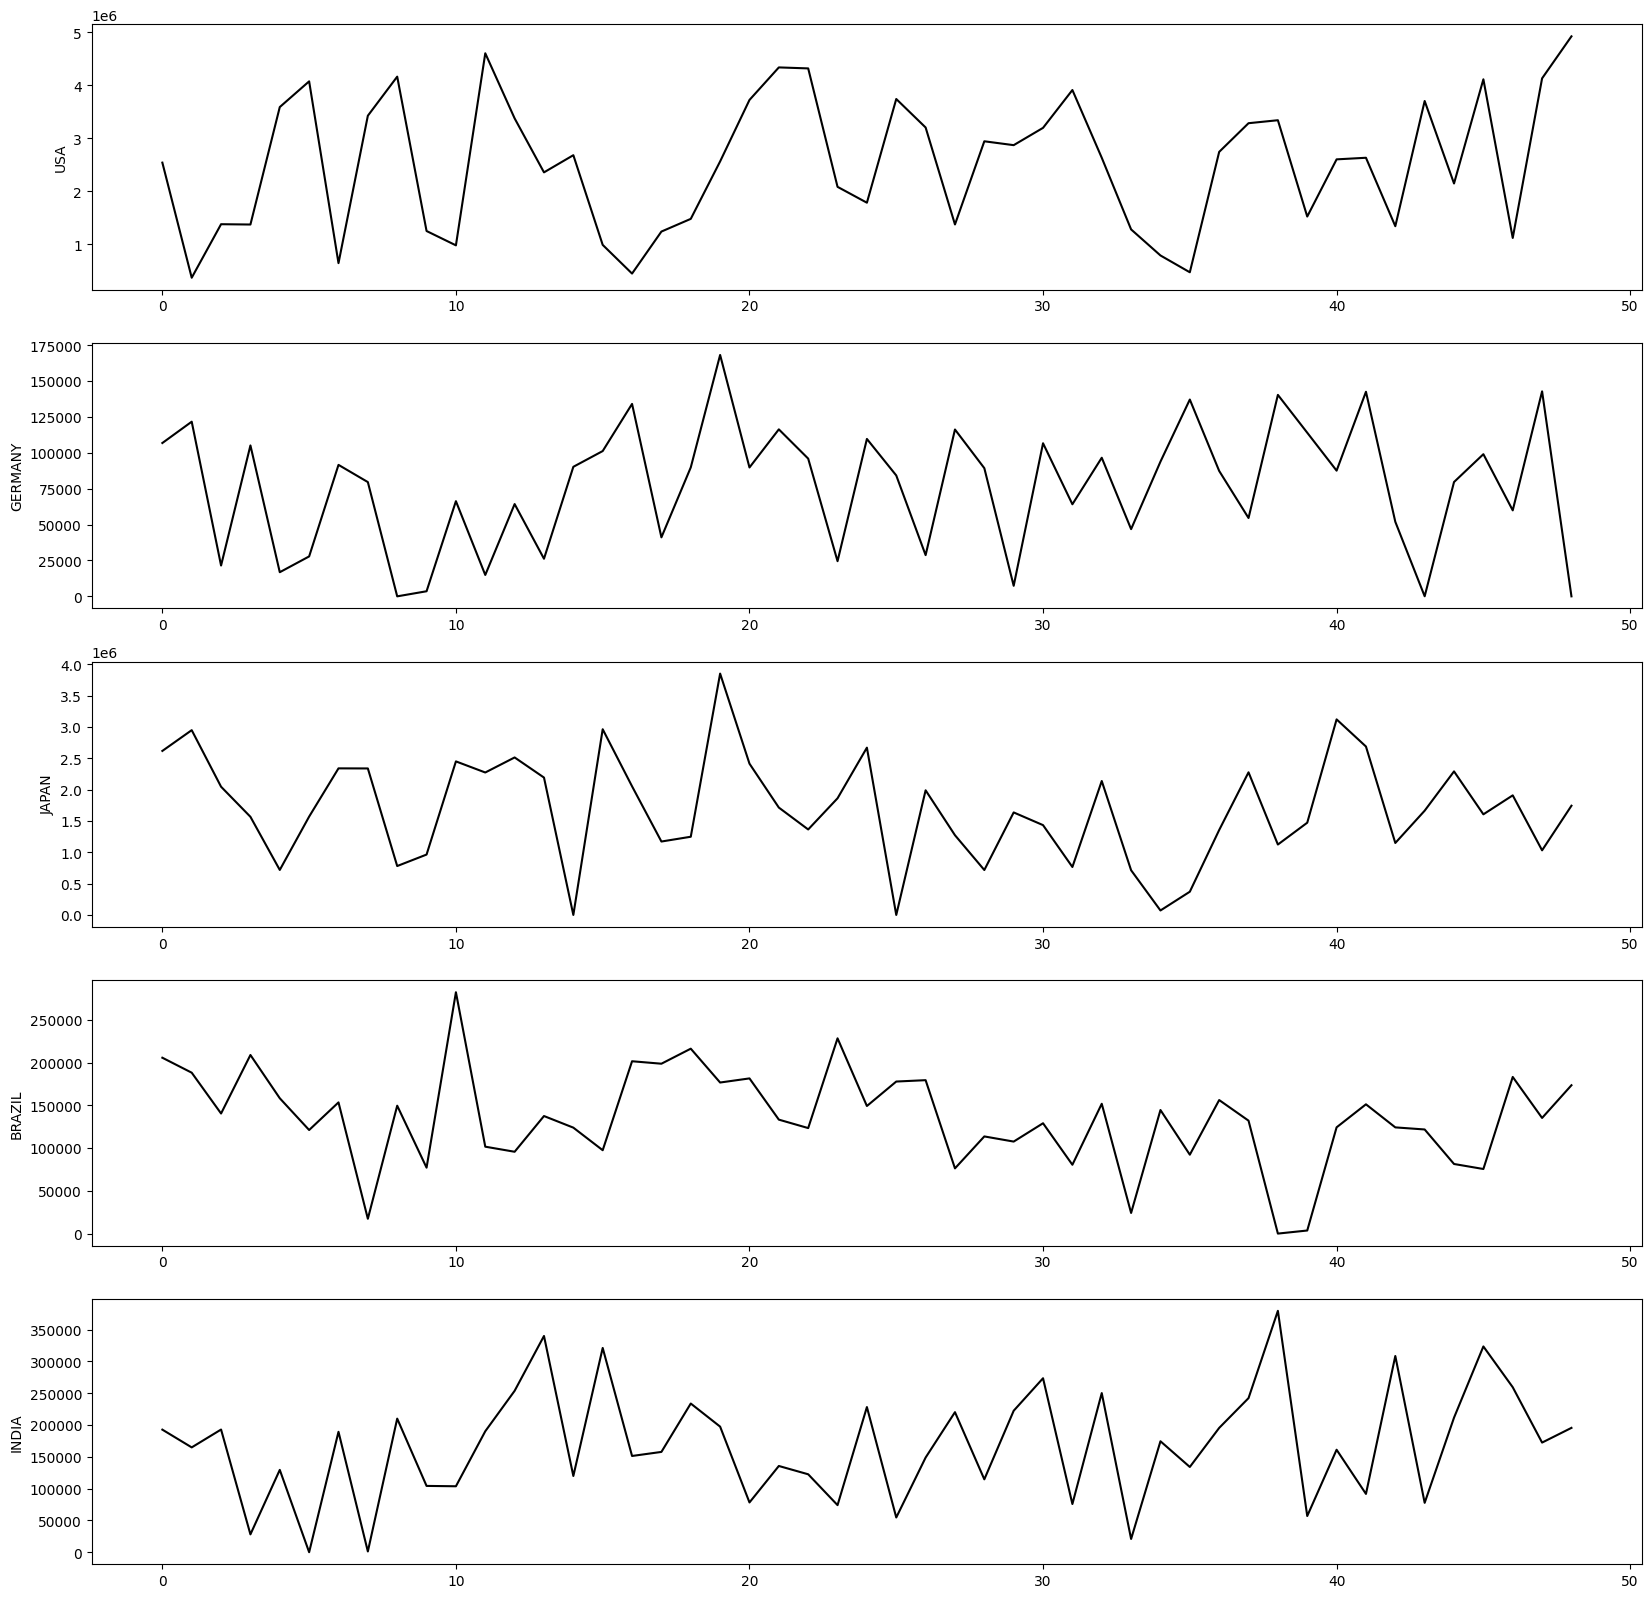

In [41]:
figure, axs = plt.subplots(5,1, figsize=(20,20))

for location in locations:
    sns.lineplot(data=demand_df, x=np.arange(0,49,1), y=location, legend=True, ax=axs[locations.index(location)], color="black")

## Finding Solutions for the Generated Scenarios 

In [42]:
statuses = []
objective_values = []

status, objective_value, plant_openings = optimize(var_costs, fixed_costs, demands, "Demand", capacities)

for i in range(0,49):
    status, objective_value, df_plant_opening = optimize(var_costs, fixed_costs, demand_df.T, i, capacities)
    statuses.append(status)
    objective_values.append(objective_value)
    plant_openings = pd.concat([plant_openings, df_plant_opening], axis=1)

In [43]:
plant_openings.columns = np.arange(1,51,1)
plant_openings = plant_openings.astype(int)
plant_openings

,1,2,3,4,5,6,7,8,9,10,...,41,42,43,44,45,46,47,48,49,50
USA_LOW,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
GERMANY_LOW,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,1,0,0,0,1,1
JAPAN_LOW,0,1,0,0,0,0,0,0,1,0,...,0,0,1,0,0,0,0,0,0,0
BRAZIL_LOW,0,1,1,1,0,0,1,0,1,1,...,0,0,1,0,1,0,0,1,1,1
INDIA_LOW,1,1,1,1,1,1,1,1,1,1,...,1,1,1,0,1,1,1,1,1,1
USA_HIGH,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,1
GERMANY_HIGH,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
JAPAN_HIGH,1,1,0,0,0,1,1,0,1,1,...,0,1,1,0,1,1,1,0,1,1
BRAZIL_HIGH,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
INDIA_HIGH,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1


## Comparing Solutions 

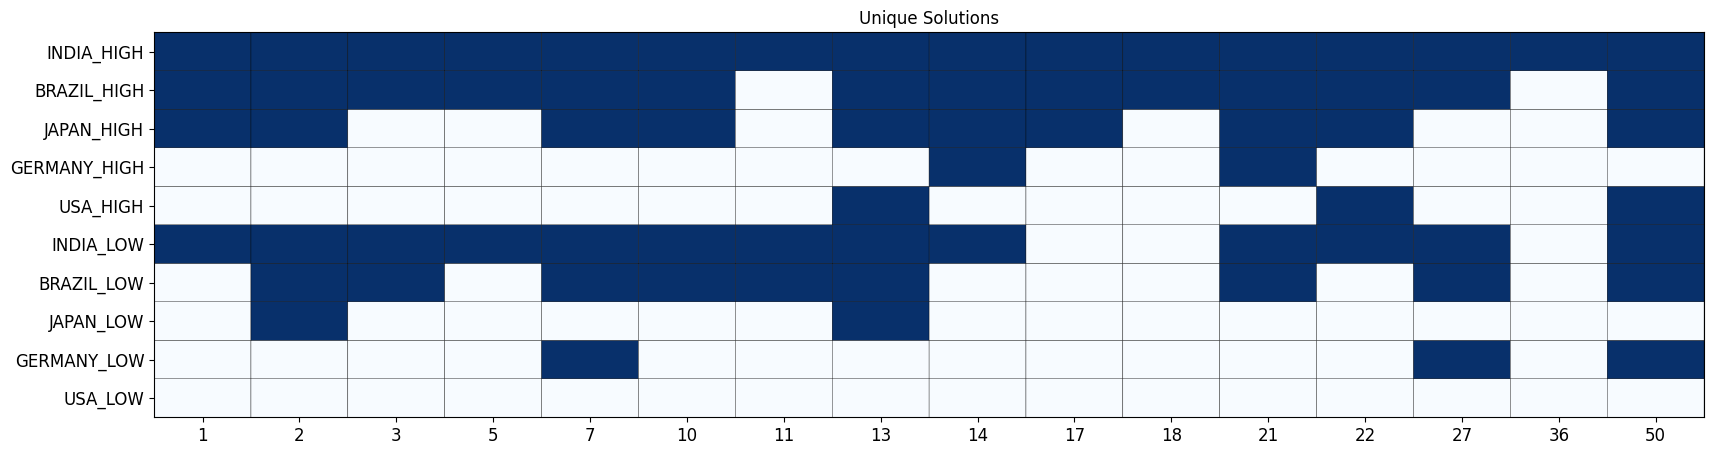

In [44]:
unique_plant_openings = plant_openings.T.drop_duplicates().T

plt.figure(figsize=(20,5))
plt.pcolor(plant_openings.T.drop_duplicates().T, cmap="Blues", edgecolors='k')
plt.yticks([i + 0.5 for i in range(plant_openings.shape[0])], plant_openings.index, fontsize=12)
plt.xticks([i + 0.5 for i in range(unique_plant_openings.shape[1])], unique_plant_openings.columns, fontsize=12)
axs=plt.gca()
axs.set_title("Unique Solutions")
plt.show()

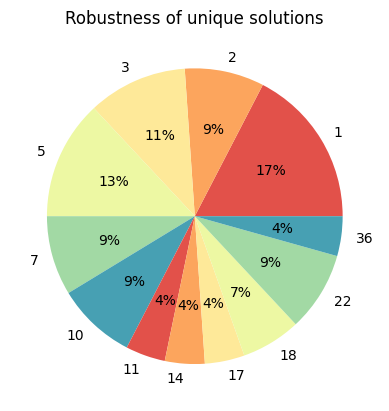

In [45]:
Optimum = []
Count = []

for c1 in unique_plant_openings:
    Optimum.append(c1)
    count = 0
    for c2 in plant_openings:
        if (plant_openings[c1]!=plant_openings[c2]).sum()==0:
            count+=1
    Count.append(count)

df_robustness = {"Optimum Solution": Optimum, "Count":Count}
df_robustness = pd.DataFrame(df_robustness)
df_robustness = df_robustness[df_robustness["Count"]>1]

palette_color = sns.color_palette('Spectral')
plt.pie(df_robustness["Count"], colors=palette_color, labels=df_robustness["Optimum Solution"],autopct='%.f%%')
axs = plt.gca()
axs.set_title("Robustness of unique solutions")
plt.show()

Hence, the solution 1 is the most robust as it withstands 17% of the scenarios. This solution can be accepted as the final plant opening plan. The solution suggests opening the following plants:
- Both high and low capacity plants in India 
- A high capacity plant in Brazil
- A high capacity plant in Japan